# Clustering

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from src import *
from src.visualization.utils import *

### Patients

The exercice on dimension reduction allowed us to create an embedding on the data missingness of the patient dataset.
The embedding showed many clusters, more or less separated and in two dimensions.
Compare the various techniques presented on this dataset, which present various real_life complications.

(13533, 2)


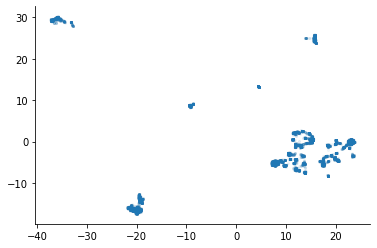

In [ ]:
to_train = np.load(ROOTDIR / 'data' / 'interim' / 'patient_empty_reduction.npy')
print(to_train.shape)
fig, ax = plt.subplots()
ax.scatter(to_train[:,0], to_train[:,1], alpha=0.05, s=4);

Our clusters are really well separated and roughly have spherical shape.
We can then start with the most simple technique : KMeans.
With these conditions the WSS method to estimate the number of cluster may seem valid.

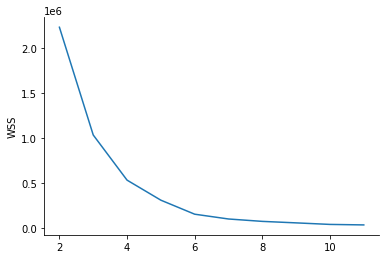

In [ ]:
from sklearn.cluster import KMeans
res = []
for n_clusters in range(2,12):
    clst = KMeans(n_clusters=n_clusters, random_state=0)
    labels = clst.fit_predict(to_train)
    score = clst.inertia_
    res.append((n_clusters, score))
    
sil, scores = zip(*res)    
fig, ax = plt.subplots()
ax.plot(sil, scores);
ax.set_ylabel('WSS');

The WSS method proposes to take about 6 clusters.
Because our data in 2D, we can directly look at what these clusters look like.
We observe that the large clusters on the edges are correctly extracted, even the purple and blue ones which are close and not very spherical.
The cluster 5 is a bit more surprising, indeed in contains 2 clusters far from each other.
In theory, the WSS plot should give  us an insight that going one cluster higher would give more sensible results.
However, there is very few points in those cluster.
As a result, they contribute very little to the WSS even tough that have large distance from the centroid.
Even with 7 clusters, KMeans will prefer split the purple cluster in two.

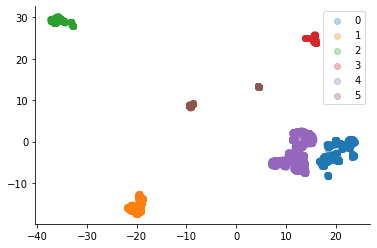

In [ ]:
n_clusters = 6
clst  = KMeans(n_clusters=n_clusters, random_state=0)
labels = clst.fit_predict(to_train)
plot_clustering(to_train, labels)

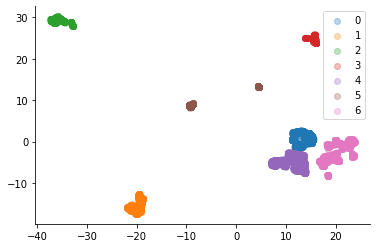

In [ ]:
n_clusters = 7
clst  = KMeans(n_clusters=n_clusters, random_state=0)
labels = clst.fit_predict(to_train)
plot_clustering(to_train, labels)

If we try DBSCAN as a density method, most of the clusters will have no trouble being correctly identiffied.
Depending on what the analyst wishes for the blue/purple cluster, a tuning of ```eps``` will be necessary to either split or merge the two clusters.

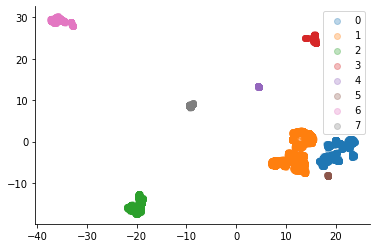

In [ ]:
from sklearn.cluster import DBSCAN
clst  = DBSCAN(eps=1.5)
labels = clst.fit_predict(to_train)
plot_clustering(to_train, labels)

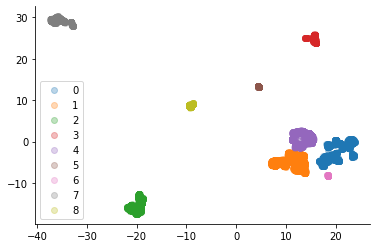

In [ ]:
from sklearn.cluster import DBSCAN
clst  = DBSCAN(eps=1.3)
labels = clst.fit_predict(to_train)
plot_clustering(to_train, labels)

This clustering looks very good visually.
Then let's look at what the silhouette score looks like in this situation.
As epxected the leftmost and top clusters are extremely well defined, and all points whithin have an excellent score above 90%.
The purple, orange and blue lusters are more ambiguous in term of silhouette score.
While the maximum value for each cluster fall above a decent 60%, the values quickly fall, meaning that multiple cluster fight for the same points.
Interestingly, it is not the fight between purple and orange that is the most fierce, even though orange suffer quite a lot for half its points.
The blue cluster is the one that has the worst metric even though it seems quite well defined.
This is an artifact that the blue cluster has not a spherical shape and that it is quite extended.
As a result, the bottom points are technically closer to the pink cluster than to the average blue ones.
This is a concrete example of the contradiction of a metric based on distance applied on a clustering algorithm based on aggregation.

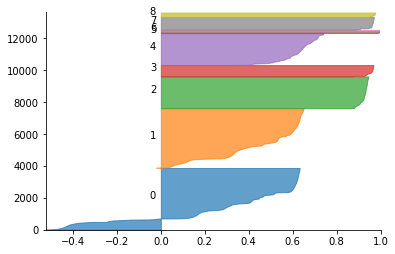

In [ ]:
draw_silhouette(to_train, labels)

## Cancer dataset

We already studied the cancer dataset in the dimension reduction course.
Now perform the complementary analysis.
Apply the various clustering algorithms on the cancer dataset, before any dimension reduction, and compare the results.
Which algorithm seem the most practical.
Is there any clusters in the dataset?
Is there any value in performing clustering on this dataset.

In this exercice, we will make a complementary analysis of the analysis of the course on dimension reduction.
This first analysis showed fuzzy clusters but an interesting separation of data points with respect to dignosis.
Here we will see what we could have gotten if we had started from clustering.

We will expect the clusters (if they exist) not to be of the same size.
Then, we will use the Gaussian mixture to try to identify the clusters.
Again, the WSS plot may not be optimal.
Hence, we will use the silhouette score to estimate the quality of clusters.

In [ ]:
fn = ROOTDIR / 'data' / 'interim' / 'breast_cancer.parquet'
df = pd.read_parquet(fn)
df.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
id                                                                         
842302           M        17.99         10.38          122.80     1001.0   
842517           M        20.57         17.77          132.90     1326.0   
84300903         M        19.69         21.25          130.00     1203.0   
84348301         M        11.42         20.38           77.58      386.1   
84358402         M        20.29         14.34          135.10     1297.0   

          smoothness_mean  compactness_mean  concavity_mean  \
id                                                            
842302            0.11840           0.27760          0.3001   
842517            0.08474           0.07864          0.0869   
84300903          0.10960           0.15990          0.1974   
84348301          0.14250           0.28390          0.2414   
84358402          0.10030           0.13280          0.1980   

          concave points_mean  symmetry_mean  ...  radius_worst  \
id                                            ...                 
842302                0.14710         0.2419  ...         25.38   
842517                0.07017         0.1812  ...         24.99   
84300903              0.12790         0.2069  ...         23.57   
84348301              0.10520         0.2597  ...         14.91   
84358402              0.10430         0.1809  ...         22.54   

          texture_worst  perimeter_worst  area_worst  smoothness_worst  \
id                                                                       
842302            17.33           184.60      2019.0            0.1622   
842517            23.41           158.80      1956.0            0.1238   
84300903          25.53           152.50      1709.0            0.1444   
84348301          26.50            98.87       567.7            0.2098   
84358402          16.67           152.20      1575.0            0.1374   

          compactness_worst  concavity_worst  concave points_worst  \
id                                                                   
842302               0.6656           0.7119                0.2654   
842517               0.1866           0.2416                0.1860   
84300903             0.4245           0.4504                0.2430   
84348301             0.8663           0.6869                0.2575   
84358402             0.2050           0.4000                0.1625   

          symmetry_worst  fractal_dimension_worst  
id                                                 
842302            0.4601                  0.11890  
842517            0.2750                  0.08902  
84300903          0.3613                  0.08758  
84348301          0.6638                  0.17300  
84358402          0.2364                  0.07678  

[5 rows x 31 columns]

In [ ]:
from sklearn.preprocessing import StandardScaler
train_cols = sorted(set(df.columns)-set(['diagnosis']))
scaler = StandardScaler()
to_train = scaler.fit_transform(df[train_cols])

[<matplotlib.lines.Line2D>]

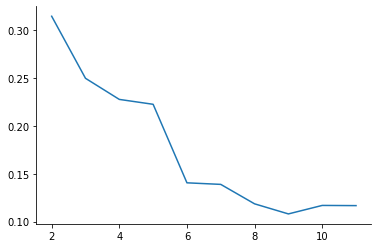

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

res = []
for n_clusters in range(2,12):
    clst = GaussianMixture(n_components=n_clusters, random_state=0)
    labels = clst.fit_predict(to_train)
    score = silhouette_score(to_train, labels)
    res.append((n_clusters, score))
    
n_clusters, scores = zip(*res)    
fig, ax = plt.subplots()
ax.plot(n_clusters, scores)

We can make two observations from this graph.
Firs, the curve is sharply decreasing, meaning that there is very few probable clusters.
The second point of observation is that the maximum average silhouette is quite small.
It result that most of the data does not clusterise well.
Let's look at the detailed silhouette plot to understand how those extracted clusters behave.

In [ ]:
n_clusters = 2
clst = GaussianMixture(n_components=n_clusters, random_state=0)
labels = clst.fit_predict(to_train)
labels_gm = labels

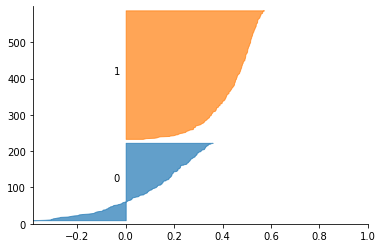

In [ ]:
from src.visualization.utils import *
draw_silhouette(to_train, labels)

This results are indicative of two bad clusters.
The blue cluster has about 30% of its data points closer to the orange points.
The there seem to be a particularly fuzzy transition between the two clusters.
Actually, the blue does not even see to be one as there is no plateau in the silhouette plot.
The orange cluster is better in that sense.
It has higher maximal value than the blue one, which would be indicative of a more elongated or more dense cluster.

As we have said in previous course that eventhough they may not be well separated, clusters may have business value.
Let's look if there is some meaning in term of diagnosis in those clusters.

In [ ]:
table = pd.pivot_table(pd.DataFrame({'label':labels, 'diagnosis':df.diagnosis, 'one':1}),
                      index='diagnosis', columns='label', values='one', aggfunc='count')
table

label        0    1
diagnosis          
B           18  339
M          196   16

Good news!

Even our 'bad' clusters have quite an interesting property.
It would seem that each cluster is quite nicely related to a diagnosis.
A bad cluster can definitely be useful.

Let's now compare what we could get with DBCAN.

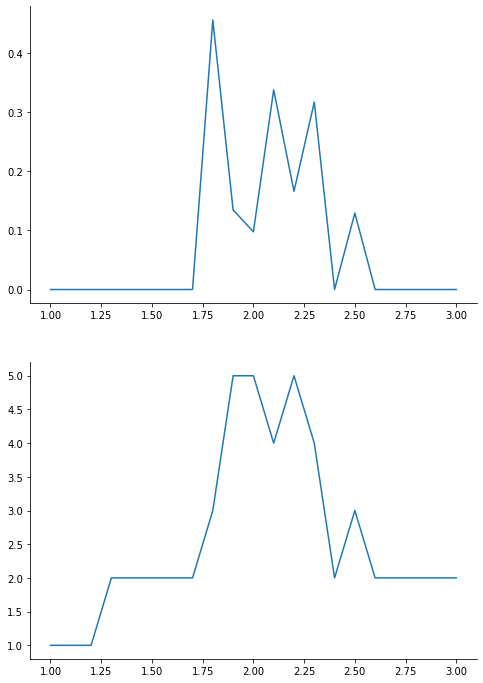

In [ ]:
from sklearn.cluster import DBSCAN

res = []
for eps in np.linspace(1, 3, 21):
    clst = DBSCAN(eps=eps)
    labels = clst.fit_predict(to_train)
    
    mask = labels != -1
    uniques = len(np.unique(labels))
    if uniques<3:
        res.append((eps, uniques, 0))
        continue
        
    score = silhouette_score(to_train[mask], labels[mask])
    res.append((eps, uniques, score))

eps, n_clusters, scores = zip(*res)    
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(8, 12))
ax0.plot(eps, scores);
ax1.plot(eps, n_clusters);

The silhouette plot of the DBSCAN algorithm has a very erratic behaviour.
The data does not seem to be adapted to density based clustering algorithms.

Here, the GM algorithms seems to give the best results.
We will continue the study by trying to visualise the clusters.
First we will look at these clusters in the UMAP embedding we already know.

In [ ]:
embedding = np.load('../../data/interim/embedding_cancer.npy')

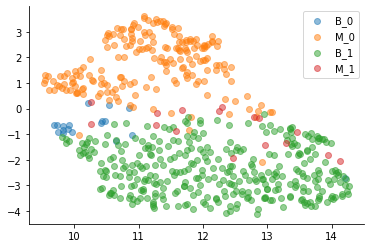

In [ ]:
fig, ax = plt.subplots()
for lab in np.unique(labels_gm):
    for diag in np.unique(df.diagnosis):
        mask = (labels_gm==lab)&(df.diagnosis==diag)
        label = '{}_{}'.format(diag, lab)
        ax.scatter(embedding[mask, 0], embedding[mask,1], label=label, alpha=0.5)
ax.legend();

At first order, the dataset is split between orange and green, malingrant tumors in label 0 and benign ones in label one.
But when we look at the details, there is an interesting behaviour.
All the points that are wrongly classified as label 1 while still being malingrant (red) are either well within green area or at the frontier.
This means that neither dimension reduction nor clustering in high dimension was able to separate thos points from benign tumors.
Those seem to really be a case of 'bas luck'.
Then, one can still obseve that a couple of orange points exist within the grey area.
This means that GM understood those points to belong to one cluster, while UMAP understood the opposite.
Those points seem ambiguous and they must belong to an interesting topology.
Finally, the blue points are also ambiguous.
GM qualify them as label 0 (but we don't know with how much certainty), while UMAP puts them on the lower cluster, and even where the separation with the upper cluster is the strongest.
There may be interesting topology in this area as well, which GM and UMAP treat very differently.